<a href="https://colab.research.google.com/github/fridaruh/report_film_genre_profitability/blob/master/report_film_genre_profitability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
import pandas as pd
import numpy as np
import os
import scipy.stats as ss
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
FILE_PATH = "/content/drive/MyDrive/Sussex/Data Science Lab/Report/Resultados/movie_metadata.csv"
TARGET_LANGUAGE = 'English'
TARGET_COUNTRY = 'UK'

In [5]:
df = pd.read_csv(FILE_PATH)

# 1. Feature Description
Description of main features (characteristics)
The dataset contains movie metadata extracted from IMDB.
Key features for profitability analysis:
- **'budget'** (budget): Financial amount assumed in USD.
- **'gross'** (gross revenue): Financial amount assumed in USD.
- **'genres'** (genres): Text describing the movie type, potentially separated by characters (e.g., '|').
- **'language'** (language): Categorical (Nominal). Example: 'English'.
- **'country'** (country): Categorical (Nominal). Example: 'UK' or 'USA'.
- **'imdb_score'**: A continuous metric for quality.


In [6]:
df.info() # Display column information and NaN count

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5043 entries, 0 to 5042
Data columns (total 28 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   color                      5024 non-null   object 
 1   director_name              4939 non-null   object 
 2   num_critic_for_reviews     4993 non-null   float64
 3   duration                   5028 non-null   float64
 4   director_facebook_likes    4939 non-null   float64
 5   actor_3_facebook_likes     5020 non-null   float64
 6   actor_2_name               5030 non-null   object 
 7   actor_1_facebook_likes     5036 non-null   float64
 8   gross                      4159 non-null   float64
 9   genres                     5043 non-null   object 
 10  actor_1_name               5036 non-null   object 
 11  movie_title                5043 non-null   object 
 12  num_voted_users            5043 non-null   int64  
 13  cast_total_facebook_likes  5043 non-null   int64

# 2. Data Wrangling and Cleaning

In [7]:
initial_len = len(df)

In [8]:
df.drop_duplicates(inplace=True, keep="first", ignore_index=True) # [9]

In [9]:
print(f"Removed {initial_len - len(df)} duplicate rows.")

Removed 45 duplicate rows.


## 2.2 Filtering (UK/English)

In [10]:
df_filtered = df[(df['language'] == TARGET_LANGUAGE) & (df['country'] == TARGET_COUNTRY)]

In [11]:
print(f"Dataset size after filtering for '{TARGET_LANGUAGE}' and '{TARGET_COUNTRY}': {len(df_filtered)} rows.")

Dataset size after filtering for 'English' and 'UK': 437 rows.


## 2.3 Missing Values (NaNs)

In [12]:
critical_cols = ['budget', 'gross', 'genres', 'imdb_score']

In [13]:
nan_indexes = df_filtered[df_filtered[critical_cols].isnull().any(axis=1)].index

In [14]:
num_nans_removed = len(nan_indexes)

Removing Rows with NaNs

In [15]:
df_clean = df_filtered.drop(nan_indexes, inplace=False)
df_clean.reset_index(drop=True, inplace=True) # Reset index

In [17]:
print(f"Removed {num_nans_removed} rows due to missing financial/genre data.")
print(f"Final cleaned dataset size: {len(df_clean)} rows.")


Removed 121 rows due to missing financial/genre data.
Final cleaned dataset size: 316 rows.


## 2.4 Feature Engineering: Profit Calculation

Calculate the main metric: Profit = Gross - Budget.

In [18]:
df_clean['profit'] = df_clean['gross'] - df_clean['budget']

In [21]:
df_clean[['movie_title', 'genres', 'budget', 'gross', 'profit', 'imdb_score']].head(5)

,movie_title,genres,budget,gross,profit,imdb_score
0,Spectre,Action|Adventure|Thriller,245000000.0,200074175.0,-44925825.0,6.8
1,Harry Potter and the Half-Blood Prince,Adventure|Family|Fantasy|Mystery,250000000.0,301956980.0,51956980.0,7.5
2,Quantum of Solace,Action|Adventure,200000000.0,168368427.0,-31631573.0,6.7
3,Skyfall,Action|Adventure|Thriller,200000000.0,304360277.0,104360277.0,7.8
4,The Jungle Book,Adventure|Drama|Family|Fantasy,175000000.0,362645141.0,187645141.0,7.8


## 3. Target criteria

In [23]:
FAILED_GENRE = 'Comedy' # Based on the scenario (last movie)
SIGNIFICANCE_LEVEL = 0.05 # Standard significance level for hypothesis testing

## 4. Genre Wrangling for EDA

Since movies can have multiple genres (pipe-separated), we create a list of all genres.

In [24]:
all_genres = df_clean['genres'].str.split('|', expand=True).stack().unique()

Genre Profit Analysis

In [25]:
genre_profit_data = []
for genre in all_genres:
    ### Genre Movie Selection
    # Identify all movies that contain this genre (using boolean indexing based on string presence)
    genre_movies = df_clean[df_clean['genres'].str.contains(genre, na=False)]

    if len(genre_movies) > 1: # Only include genres with enough data points
        genre_profit_data.append({
            'genre': genre,
            'count': len(genre_movies),
            'mean_profit': genre_movies['profit'].mean(),
            'median_profit': genre_movies['profit'].median(),
            'total_profit': genre_movies['profit'].sum()
        })


In [26]:
df_genres = pd.DataFrame(genre_profit_data)

### Sorting Genres

In [27]:
df_genres_sorted = df_genres.sort_values(by='mean_profit', ascending=False).reset_index(drop=True)

### Best Genre Selection

Select the best genre, ensuring it is not "Comedy".
If Comedy is Action, Drama or Romance (e.g.), we exclude Comedy from the recommendation.


In [29]:
BEST_GENRE = df_genres_sorted[~df_genres_sorted['genre'].str.contains(FAILED_GENRE)].iloc[0]['genre']

In [30]:
print(f"Most Profitable Genre Identified (excluding Comedy): {BEST_GENRE}")

Most Profitable Genre Identified (excluding Comedy): Family


In [31]:
# Create subsets for visualization and comparison
df_best_genre = df_clean[df_clean['genres'].str.contains(BEST_GENRE, na=False)]
df_failed_genre = df_clean[df_clean['genres'].str.contains(FAILED_GENRE, na=False)]


## Visualization (EDA)

In [32]:
df_temp_comparison = pd.concat([
    df_best_genre.assign(group=BEST_GENRE), # .assign() to create temporary column [20]
    df_failed_genre.assign(group=FAILED_GENRE)
])

Text(0.5, 0, 'Genre')

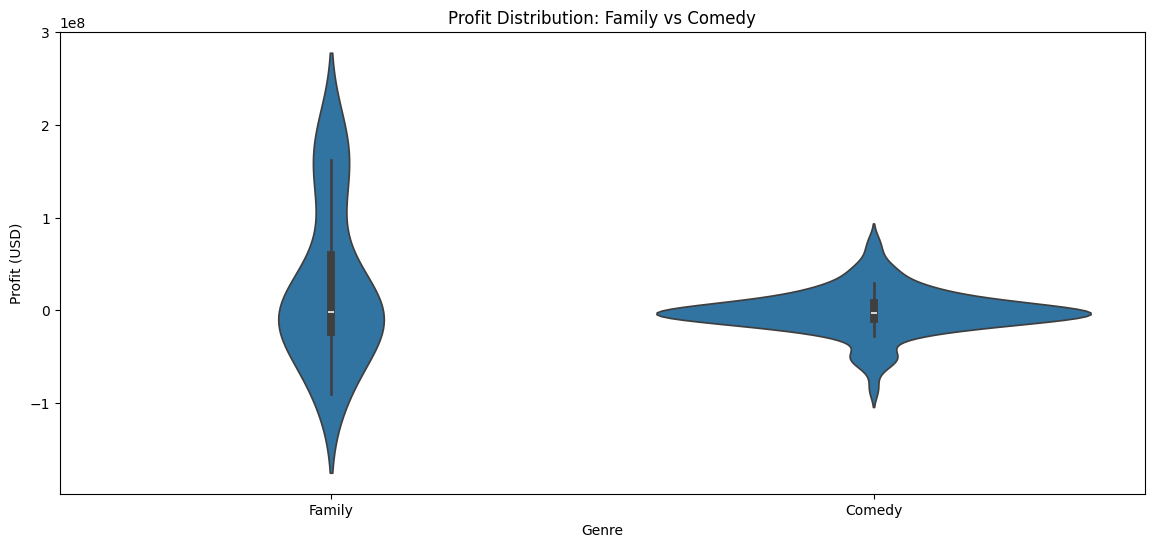

In [35]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.violinplot(data=df_temp_comparison, y='profit', x='group', ax=ax)
ax.set_title(f"Profit Distribution: {BEST_GENRE} vs {FAILED_GENRE}")
ax.set_ylabel("Profit (USD)")
ax.set_xlabel("Genre")

Text(0.5, 0, 'Genre')

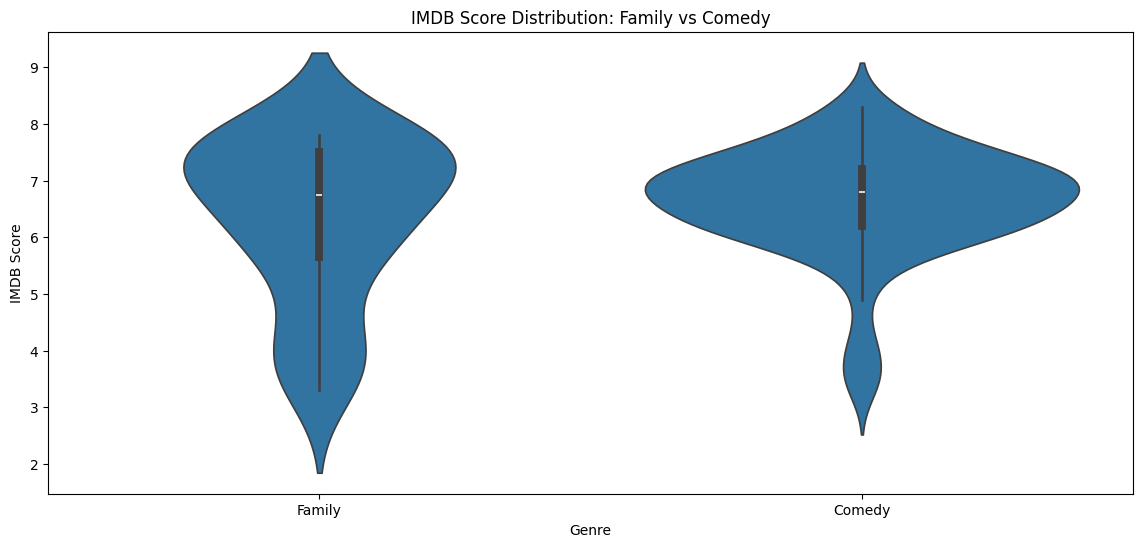

In [37]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.violinplot(data=df_temp_comparison, y='imdb_score', x='group', ax=ax)
ax.set_title(f"IMDB Score Distribution: {BEST_GENRE} vs {FAILED_GENRE}")
ax.set_ylabel("IMDB Score")
ax.set_xlabel("Genre")

## 4. Hypothesis Testing

In [41]:
data_best_genre = df_best_genre['profit']
data_failed_genre = df_failed_genre['profit']

In [43]:
alpha = SIGNIFICANCE_LEVEL

In [46]:
if len(data_best_genre) > 1 and len(data_failed_genre) > 1:

    ### T-Test Execution
    # Perform the t-test
    result = ss.ttest_ind(data_best_genre, data_failed_genre, alternative="greater", equal_var=False)

    print(f"Comparing {BEST_GENRE} vs {FAILED_GENRE}")
    print(f"Test Statistic = {result.statistic:.4f}")
    print(f"P-value = {result.pvalue:.4f}")

    ### Decision Statement
    # Write the decision statement
    if result.pvalue < alpha:
        print(f"Decision: Reject the null hypothesis at the {alpha*100}% significance level.")
    else:
        print(f"Decision: Fail to reject the null hypothesis at the {alpha*100}% significance level.")
else:
    print("Warning: Insufficient data points in one or both genres to conduct the two-sample t-test.")

Comparing Family vs Comedy
Test Statistic = 1.8104
P-value = 0.0400
Decision: Reject the null hypothesis at the 5.0% significance level.
